In [65]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
from statsmodels.tsa.ar_model import AR
%matplotlib notebook

In [66]:
def missing_values_table(df):
    """
    Input: A data frame
    Ouput: Amount of missing values,
         Percentage of missing values in each feature
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [76]:
def plot_3d_nelson_siegel(data, yearly_maturity):
    x = np.array(np.linspace(2009, 2015, 1768))
    y = yearly_maturity
    x, y = np.meshgrid(x, y)
    z = data.values.T
    assert x.shape == y.shape, 'Wrong shape'
    assert x.shape == z.shape, 'Wrong shape'

    # Set up plot
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    # fig, ax = plt.fig(subplot_kw=dict(projection='3d'))

    ls = LightSource(270, 45)
    # To use a custom hillshading mode, override the built-in shading and pass
    # in the rgb colors of the shaded surface calculated from "shade".
    rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                           linewidth=0, antialiased=False, shade=False)
    # rotate the axes and update
    for angle in range(0, 360):
        ax.view_init(30, angle)
        plt.draw()
        plt.pause(.001)
    plt.show()
    return None

In [67]:
data = pd.read_csv('OIS-daily-data_2009-to-2015.csv')
print("Number of (row, column): ", data.shape)

Number of (row, column):  (1825, 61)


# Formatting and Cleaning data

In [19]:
# Select maturity and columns
yearly_maturity = np.array(
    [0.33, 0.67, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00])
column_maturity = [
    'maturity_0.33', 'maturity_0.67', 'maturity_1.00', 'maturity_1.50', 'maturity_2.00',
    'maturity_2.50', 'maturity_3.00', 'maturity_3.50', 'maturity_4.00',
    'maturity_4.50', 'maturity_5.00'
]

Data shape after removing null rows:  (1768, 60)


In [68]:
# Format data
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', drop=True, inplace=True)
data.dropna(inplace=True)
print("Data shape after removing null rows: ", data.shape)
data = data[column_maturity]

Data shape after removing null rows:  (1768, 60)


NelsonSiegelCurve(beta0=149.65750434369866, beta1=-149.09994369145954, beta2=-152.15195857259604, tau=27.686105780543457)


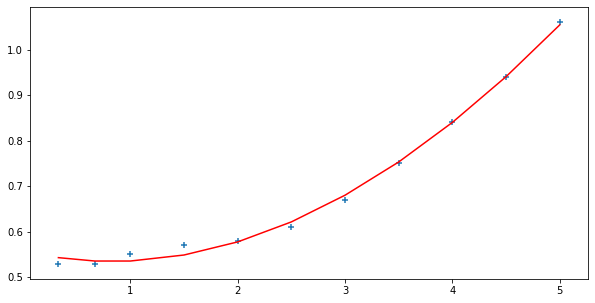

In [23]:
y = data.loc['2011-11-07'].values

curve, status = calibrate_ns_ols(yearly_maturity, y, tau0=0.5)
assert status.success, 'Fail to optimize'
print(curve)

plt.figure(figsize=(10,5))
plt.plot(yearly_maturity, curve(yearly_maturity), c='red')
plt.scatter(yearly_maturity, y, marker='+')
plt.show()

In [24]:
def compute_nelson_param(df):
    y = df.values
    t = yearly_maturity
    tau = 0.5
    while True:
        try: 
            curve, status = calibrate_ns_ols(yearly_maturity, y, tau0=tau)
            if status.success:
                return [curve.beta0, curve.beta1, curve.beta2, curve.tau]
        except:
            tau += 0.5
            pass

In [25]:
data[['beta0', 'beta1', 'beta2', 'tau']] = data.apply(lambda x: pd.Series(compute_nelson_param(x), index=['beta0', 'beta1', 'beta2', 'tau']), axis=1)

In [81]:
data.sort_values(by='maturity_1.00', ascending=False)

,maturity_0.33,maturity_0.67,maturity_1.00,maturity_1.50,maturity_2.00,maturity_2.50,maturity_3.00,maturity_3.50,maturity_4.00,maturity_4.50,maturity_5.00,beta0,beta1,beta2,tau
date,,,,,,,,,,,,,,,
2011-02-22,0.66,0.82,0.98,1.22,1.47,1.70,1.92,2.11,2.29,2.45,2.60,4.463459,-3.936584,-2.803155,1.517202
2011-04-05,0.70,0.84,0.98,1.23,1.49,1.73,1.95,2.14,2.32,2.48,2.63,4.257989,-3.647362,-3.149050,1.272797
2011-02-23,0.64,0.81,0.96,1.20,1.43,1.67,1.89,2.10,2.28,2.44,2.58,4.541146,-4.021623,-2.928511,1.550690
2009-01-06,0.96,0.90,0.96,1.19,1.48,1.75,1.98,2.16,2.31,2.44,2.54,3.547040,-2.203047,-4.790216,0.719803
2011-02-18,0.65,0.81,0.96,1.20,1.46,1.70,1.93,2.14,2.33,2.50,2.66,4.693185,-4.157283,-3.210643,1.516669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,0.38,0.31,0.27,0.24,0.23,0.24,0.27,0.31,0.37,0.45,0.54,9.120192,-8.676843,-11.311190,5.573812
2012-07-30,0.35,0.30,0.26,0.23,0.23,0.24,0.28,0.34,0.42,0.51,0.61,13.950643,-13.533243,-16.522580,6.662547
2012-08-06,0.37,0.30,0.26,0.23,0.23,0.24,0.28,0.33,0.40,0.48,0.57,5.853919,-5.411791,-7.598555,4.157120


In [29]:
# data.to_csv('data_NS_params.csv')

In [69]:
data = pd.read_csv('data_NS_params.csv', index_col=0)

<IPython.core.display.Javascript object>


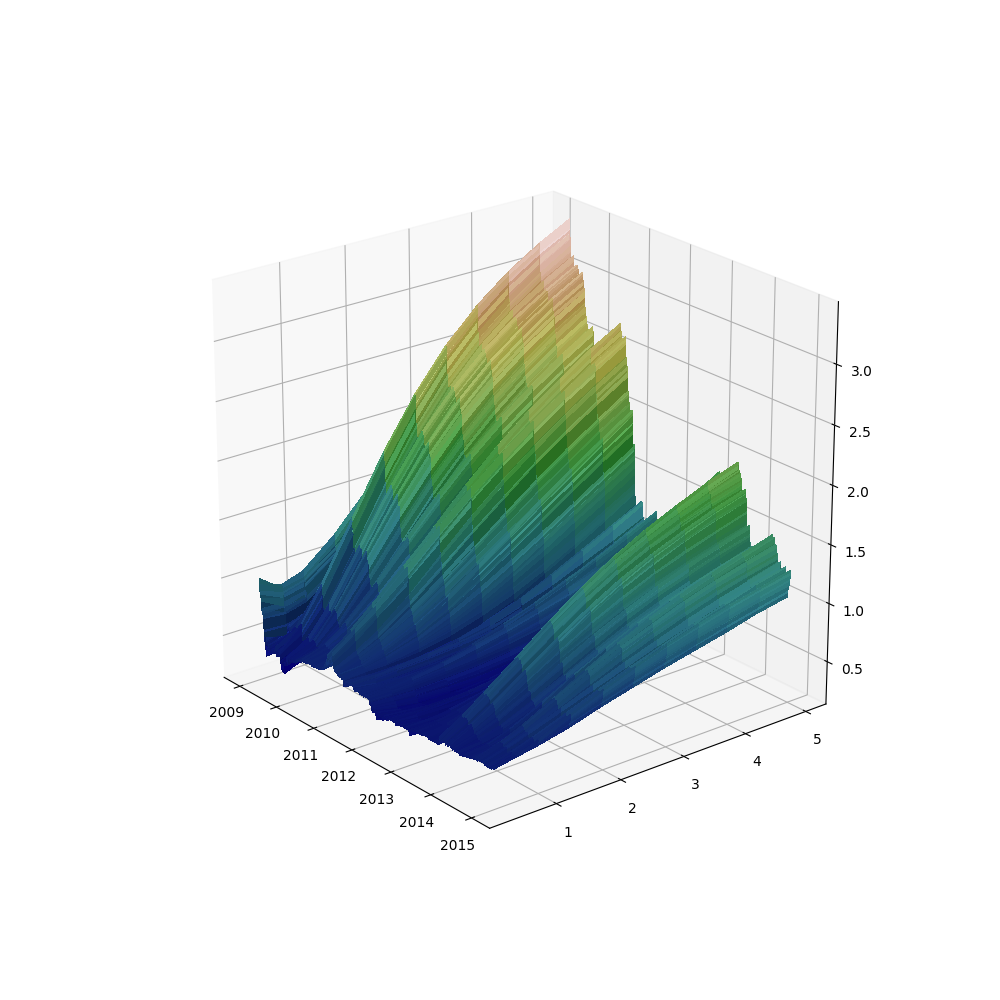

In [78]:
plot_3d_nelson_siegel(data[column_maturity], yearly_maturity)